In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm

----
# 0. ROC和准确率计算函数准备

In [2]:
def threshold(x,lim): #按要求阈值映射p，并返回按该阈值得到的预测结果
    if x<lim:
        return 0
    else:
        return 1
    
def get_p(params, data, lim): # X和逻辑回归的参数params点乘得到结果p
    data = data[list(params.index[1:])]
    snip = pd.Series({'Intercept':params[0]})
    params = params.drop('Intercept')
    params =params.append(snip)
    data = data.copy()
    data['norm'] = [1 for _ in range(len(data))]
    sigma = np.dot(data,params)
    data['p'] = 1 / (1 + np.exp(-sigma))
    data['p'] = data['p'].apply(threshold, lim=lim)
    return data['p']

def accuracy(params, data):
    data['p'] = get_p(params=params, data=data, lim=0.5)
    print('accuracy:',sum(data.p==data.trip_m_wd_am)/len(data))
    
def tf_cal(params, data, lim):
    data['p'] = get_p(params=params, data=data, lim=lim)
    TP = len(data.loc[(data.trip_m_wd_am==1) & (data.p==1)])
    FP = len(data.loc[(data.trip_m_wd_am==0) & (data.p==1)])
    TN = len(data.loc[(data.trip_m_wd_am==0) & (data.p==0)])
    FN = len(data.loc[(data.trip_m_wd_am==1) & (data.p==0)])
    return TP,FN,FP,TN

def tf_tab(params, data):
    TP,FN,FP,TN = tf_cal(params=params, data=data, lim=0.5)
    print('TP:{}\tFN:{}\nFP:{}\tTN:{}'.format(TP,FN,FP,TN))

In [3]:
def polygon_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
def roc_plot(params, data, figname):
    FPR = []
    TPR = []
    AUC = 0
    plt.style.use('ggplot')
    # plt.figure(figsize=[8,9])
    for i in tqdm(np.arange(start=0,stop=1,step=0.01)):
        TP,FN,FP,TN = tf_cal(params=params, data=data, lim=i)
        tpr = TP/(TP+FN)
        fpr = FP/(FP+TN)
        TPR.append(tpr)
        FPR.append(fpr)
    plotdf = pd.DataFrame({'TPR':TPR,'FPR':FPR})
    sns.lineplot(data=plotdf,x='FPR',y='TPR')    
    plt.title('ROC of Current Model with '+figname)
    AUC = polygon_area(FPR+[1],TPR+[0])
    plt.text(x=0.4, y=0.4, s='AUC = {:.4f}'.format(AUC), size=12)
    
    plt.savefig('./pics/'+figname+'.jpg',dpi=400)

In [4]:
def experiment_overview(train_data,test_data,result):
    %matplotlib inline
    print('dropped:')
    print(set(train_data.drop('trip_m_wd_am',axis=1).columns) - set(result.params.index))
    print('train:')
    accuracy(params=result.params, data=train_data)
    tf_tab(params=result.params, data=train_data)
    roc_plot(params=result.params, data=data, figname='default_train')
    print('--------------------------------')
    print('test:')
    accuracy(params=result.params, data=test_data)
    tf_tab(params=result.params, data=test_data)
    roc_plot(params=result.params, data=data, figname='default_test')

----
# 1. 数据准备

In [5]:
def zero_one_map(x):
    if x!=0:
        return 1
    else:
        return 0
# df['trip_m6_wd_am'] = df['trip_m6_wd_am'].apply(zero_one_map)


df = pd.read_csv('./og_data/0.csv')
df.columns=['ori','dst','dist_km','fsize_m_wd_am','trip_m_wd_am',\
                        'community_m','mrt_km_o','entro_o','cycle_km_o','far_hdb_o',\
                            'far_priv_o','far_comm_o','mrt_km_d','entro_d','cycle_km_d',\
                                'far_hdb_d','far_priv_d','far_comm_d']
df['trip_m_wd_am'] = df['trip_m_wd_am'].apply(zero_one_map)
df.drop(['ori','dst'], inplace=True, axis=1)
# df = df/4

# for i in range(2,7,2):
#     ndf = pd.read_csv('./og_data/{}.csv'.format(i))
#     ndf.columns=['ori','dst','dist_km','fsize_m_wd_am','trip_m_wd_am',\
#                         'community_m','mrt_km_o','entro_o','cycle_km_o','far_hdb_o',\
#                             'far_priv_o','far_comm_o','mrt_km_d','entro_d','cycle_km_d',\
#                                 'far_hdb_d','far_priv_d','far_comm_d']
#     ndf['trip_m_wd_am'] = ndf['trip_m_wd_am'].apply(zero_one_map)
#     ndf.drop(['ori','dst'], inplace=True, axis=1)
#     df = pd.concat([df,ndf],axis=0)
#     i += 2
# df['trip_m_wd_am'] = np.round(df['trip_m_wd_am'])
# sg = pd.read_csv('./og_data/sg_map.csv')


In [6]:
df


,dist_km,fsize_m_wd_am,trip_m_wd_am,community_m,mrt_km_o,entro_o,cycle_km_o,far_hdb_o,far_priv_o,far_comm_o,mrt_km_d,entro_d,cycle_km_d,far_hdb_d,far_priv_d,far_comm_d
0,0.38,0.000000,0,0,3.27,0.000000,0.00,0.000000,0.000000,0.000000,3.64,0.0,0.0,0.0,0.0,0.0
1,0.83,0.136364,0,0,3.14,0.356207,0.00,0.000000,0.000000,0.000000,3.64,0.0,0.0,0.0,0.0,0.0
2,1.05,0.590909,0,0,2.91,0.000000,0.00,0.000000,0.000000,0.000000,3.64,0.0,0.0,0.0,0.0,0.0
3,4.57,15.409091,0,0,1.97,0.545217,0.00,0.000442,0.000000,0.000000,3.64,0.0,0.0,0.0,0.0,0.0
4,4.21,62.954545,0,0,0.52,0.634222,0.52,0.742848,0.000000,0.536386,3.64,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241233,0.00,0.000000,0,0,7.79,0.000000,0.00,0.000000,0.000000,0.000000,7.48,0.0,0.0,0.0,0.0,0.0
241234,2.82,0.545455,0,0,4.41,0.576876,0.00,0.000000,0.444713,0.121815,6.05,0.0,0.0,0.0,0.0,0.0
241235,8.49,0.000000,0,0,1.46,0.000000,0.00,0.000000,0.000000,0.000000,7.79,0.0,0.0,0.0,0.0,0.0
241236,3.12,0.000000,0,0,6.05,0.000000,0.00,0.000000,0.000000,0.000000,7.10,0.0,0.0,0.0,0.0,0.0


In [7]:
# sg['ori'] =  sg['id']
# sg['dst'] =  sg['id']
# sg0 = sg[['ori','Lat','Lon']].copy()
# sg0 = sg0.rename(columns={'Lat':'ori_Lat','Lon':'ori_Lon'})

# sg1 = sg[['dst','Lat','Lon']].copy()
# sg1 = sg1.rename(columns={'Lat':'dst_Lat','Lon':'dst_Lon'})

# df = pd.merge(df,sg0,how='inner',on='ori')
# df = pd.merge(df,sg1,how='inner',on='dst')


# df['dist'] = np.arccos(\
#                     (np.sin(df['ori_Lat']) * np.sin(df['dst_Lat']))+\
#                     (np.cos(df['ori_Lat']) * np.cos(df['dst_Lat']) * np.cos(df['ori_Lon'] - df['dst_Lon']))\
#                     )*6371.004
# df.head()

In [6]:
# X_train,X_test, y_train, y_test = train_test_split(df.drop('trip_m6_wd_am',axis=1),df['trip_m6_wd_am'],test_size=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(df.drop('trip_m_wd_am',axis=1),df['trip_m_wd_am'],test_size=0.3, random_state=0)

train_col = X_train.columns
test_col = X_test.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(X_train, columns=train_col)
X_test = pd.DataFrame(X_test, columns=test_col)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

data =pd.concat([X_train,y_train],axis=1)

In [9]:
set(data.trip_m_wd_am)

{0, 1}

In [30]:
# plt.figure(figsize=[20,6])
# sns.boxplot(data=data)
# plt.savefig('./pics/Box Plot.jpg',dpi=400)

----
# 2. 逐步回归观察显著性并缩小变量范围

In [11]:
def stepwise_select(data, response):
    
    def forward_method(data, response, selected):
        initial_selected_num = len(selected)
        remaining = set(data.columns)
        remaining.remove(response)
        # 去掉已选定的变量
        for a in selected:
            remaining.remove(a)
        current_score, best_new_score = float('inf'), float('inf')
        initial_selected_num = len(selected)
        
        while remaining:
            aic_with_candidates=[]
            for candidate in remaining:
                formula = "{} ~ {}".format(
                    response,' + '.join(selected + [candidate]))
                link = sm.families.links.logit()
                aic = smf.glm(
                    formula=formula, data=data, 
                    family=sm.families.Binomial(link)
                ).fit().aic
                aic_with_candidates.append((aic, candidate))
            aic_with_candidates.sort(reverse=True)
            best_new_score, best_candidate=aic_with_candidates.pop()
            if current_score > best_new_score: 
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
                print ('aic is {},continuing!'.format(current_score))
            else:        
                print ('forward selection over!')
                break
            print(len(selected) - initial_selected_num)
            if (len(selected) - initial_selected_num) % 4 == 0:
                formula = "{} ~ {} ".format(response,' + '.join(selected))
                print('formula is {}'.format(formula))
                selected = backward_method(data, response, selected)

        formula = "{} ~ {} ".format(response,' + '.join(selected))
        print('formula is {}'.format(formula))
        link = sm.families.links.logit()
        model = smf.glm(
            formula=formula, data=data, 
            family=sm.families.Binomial(link)
        )
        return(model)

    def backward_method(data, response,selected):
        #selected = list(selected)
        print("-"*100)
        removed = []
        # 初始化赋值
        best_new_score = float('inf')
        # 全部特征的AIC作为初始参数
        formula = "{} ~ {}".format(
                    response,' + '.join(selected))
        link = sm.families.links.logit()
        current_score = smf.glm(
            formula=formula, data=data, 
            family=sm.families.Binomial(link)
        ).fit().aic
        print ('initial aic is {}!'.format(current_score))
        print('initial formula is {}'.format(formula))
        while selected:
            aic_with_candidates=[]
            for candidate in selected:
                select_tmp = selected.copy()
                select_tmp.remove(candidate)
                formula = "{} ~ {}".format(
                    response,' + '.join(select_tmp))
                link = sm.families.links.logit()
                aic = smf.glm(
                    formula=formula, data=data, 
                    family=sm.families.Binomial(link)
                ).fit().aic
                aic_with_candidates.append((aic, candidate))
            aic_with_candidates.sort(reverse=True)
            best_new_score, best_candidate=aic_with_candidates.pop()
            if current_score > best_new_score: 
                selected.remove(best_candidate)
                removed.append(best_candidate)
                current_score = best_new_score
                print ('worse feature, removing {}'.format(best_candidate))
                print ('aic is {},continuing!'.format(current_score))
            else:        
                print ('backward selection over!')
                break

        formula = "{} ~ {} ".format(response,' + '.join(selected))
        print('final formula is {}'.format(formula))
        return(selected)
    
    selected = []
    return forward_method(data, response, selected)


In [7]:
def groups_select(data, num, response):
    kf = KFold(n_splits=num)
    drop_record = []
    for i,_ in kf.split(data):
        data_i = data.iloc[i]
        model_i = stepwise_select(data=data_i, response=response)
        result_i = model_i.fit()
        dropped = set(list(data_i.columns))-set(list(result_i.params.index))
        print(dropped)
        print(result_i.summary())
        drop_record.append(dropped)
    return drop_record
# groups_select(data=data, num=20, response='trip_m_wd_am')       

In [12]:
drop_record = [{'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'trip_m_wd_am'},
 {'far_hdb_d', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'},
 {'far_hdb_d', 'trip_m_wd_am'},
 {'far_hdb_d', 'mrt_km_o', 'trip_m_wd_am'}]

In [8]:
X_train = X_train.drop(['far_hdb_d','mrt_km_o'],axis=1)
X_test = X_test.drop(['far_hdb_d','mrt_km_o'],axis=1)
data = pd.concat([X_train,y_train],axis=1)
test_data = pd.concat([X_test,y_test],axis=1)

In [14]:


best_model = stepwise_select(data=data, response='trip_m_wd_am')
result = best_model.fit()
result.summary()

aic is 135241.02545979418,continuing!
1
aic is 132341.21052024362,continuing!
2
aic is 131334.0259078679,continuing!
3
aic is 130501.3971543113,continuing!
4
formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_m + mrt_km_d 
----------------------------------------------------------------------------------------------------
initial aic is 130501.3971543113!
initial formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_m + mrt_km_d
backward selection over!
final formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_m + mrt_km_d 
aic is 129946.16640744107,continuing!
5
aic is 129693.88785022356,continuing!
6
aic is 129592.13408783918,continuing!
7
aic is 129531.34416019714,continuing!
8
formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_m + mrt_km_d + far_hdb_o + far_comm_d + entro_d + far_priv_d 
----------------------------------------------------------------------------------------------------
initial aic is 129531.34416019714!
initial formula is tr

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           trip_m_wd_am   No. Observations:               168866
Model:                            GLM   Df Residuals:                   168852
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64675.
Date:                Wed, 06 Apr 2022   Deviance:                   1.2935e+05
Time:                        08:57:25   Pearson chi2:                 2.63e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.1244      0.010   -210.336      0.000      -2.144      -2.105
dist_km          -1.4437      0.014   -105.275      0.000      -1.471      -1.417
fsize_m_wd_am     0.2894      0.007     42.876      0.000       0.276       0.303
community_m       0.1584      0.005     28.920      0.000       0.148       0.169
mrt_km_d         -0.1877      0.009    -20.840      0.000      -0.205      -0.170
far_hdb_o         0.1612      0.007     21.815      0.000       0.147       0.176
far_comm_d        0.1084      0.007     15.328      0.000       0.095       0.122
entro_d           0.0733      0.007     10.059      0.000       0.059       0.088
far_priv_d       -0.0683      0.008     -8.889      0.000      -0.083      -0.053
far_priv_o        0.0578      0.007      7.813      0.000       0.043       0.072
cycle_km_o        0.0369      0.007      5.534      0.000       0.024       0.050
far_comm_o       -0.0409      0.008     -4.930      0.000      -0.057      -0.025
cycle_km_d        0.0294      0.007      4.303      0.000       0.016       0.043
entro_o           0.0256      0.007      3.481      0.000       0.011       0.040
=================================================================================
"""

dropped:
set()
train:
accuracy: 0.8451849395378584
TP:3175	FN:24954
FP:1189	TN:139548


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------
test:
accuracy: 0.8475791742662908
TP:1378	FN:10516
FP:515	TN:59963


  0%|          | 0/100 [00:00<?, ?it/s]

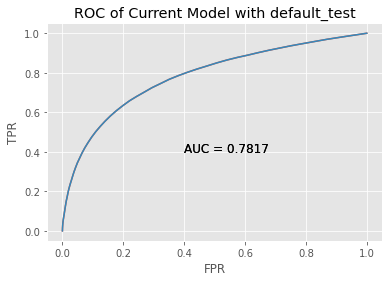

In [36]:
%matplotlib inline
experiment_overview(train_data=data, test_data=test_data, result=result)

----
# 4. 观察选中变量线性关系

In [15]:

def logit_calc(column_name,df=df):
    df['n_'+column_name] = df[column_name]
    if len(set(df['n_'+column_name]))>10:
        df['n_'+column_name] = pd.qcut(df['n_'+column_name], q=10, duplicates='drop')
    else:
        pass
    # data = df.groupby('n_'+column_name)['trip_m6_wd_am'].agg('mean')
    data = df.groupby('n_'+column_name)['trip_m_wd_am'].agg('mean').sort_index()
    data = np.log(data)-np.log(1-data)
    del df['n_'+column_name]
    return data
    # df = df.drop('n_'+column_name)

def corr_plot(df):
    plt.figure(figsize=[10,10])
    sns.heatmap(df.corr(), cmap='Blues', annot=True, annot_kws={'size':8,'weight':'normal'})
    plt.title('Corr Map')
    plt.savefig('./pics/Corr Map.jpg', dpi=400)

def bin_plot(ax,column_name,df=df):
    data = logit_calc(column_name,df)
    ax.set_title(column_name)
    ax.plot(range(1,len(data)+1), data)

def logit_plot(result,figname):
    l = len(result.params)-1
    if l % 4 ==0:
        rows = l // 4
    else:
        rows = l // 4 + 1
    fig, ax = plt.subplots(rows,4,figsize=(14,rows*3.5))

    for i in range(len(result.params.index.drop('Intercept'))):
        column_name = result.params.index.drop('Intercept')[i]
        bin_plot(ax=ax[i//4][i%4], column_name=column_name, df=data)
        # df = df.drop('n_'+column_name)
    plt.savefig('./pics/{}.jpg'.format(figname),dpi=400)
    


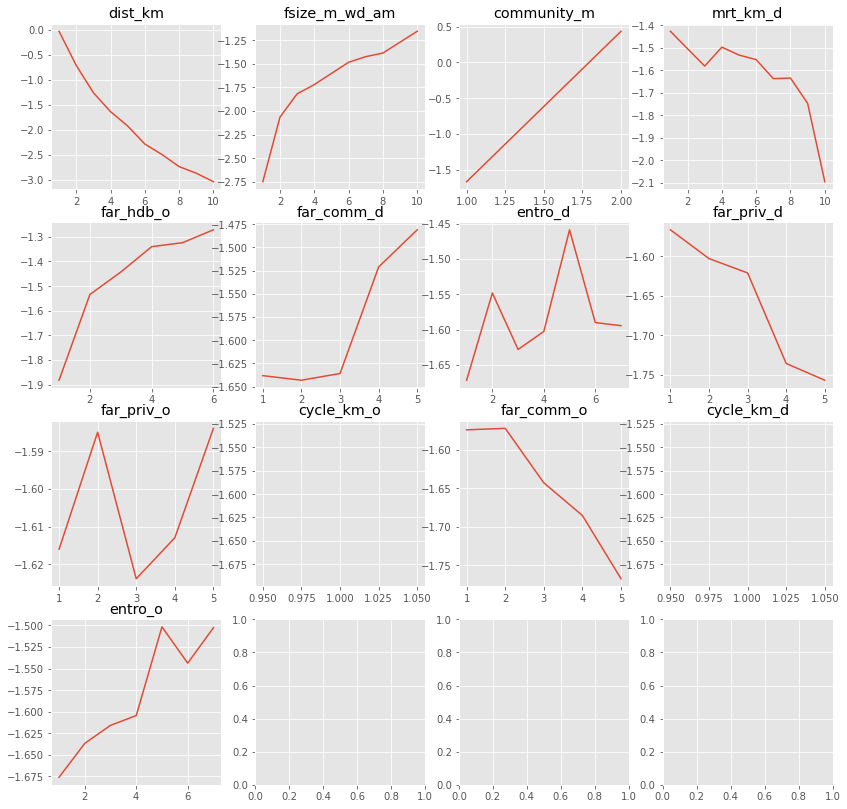

In [19]:
plt.style.use('ggplot')
logit_plot(result=result,figname='logit_features')


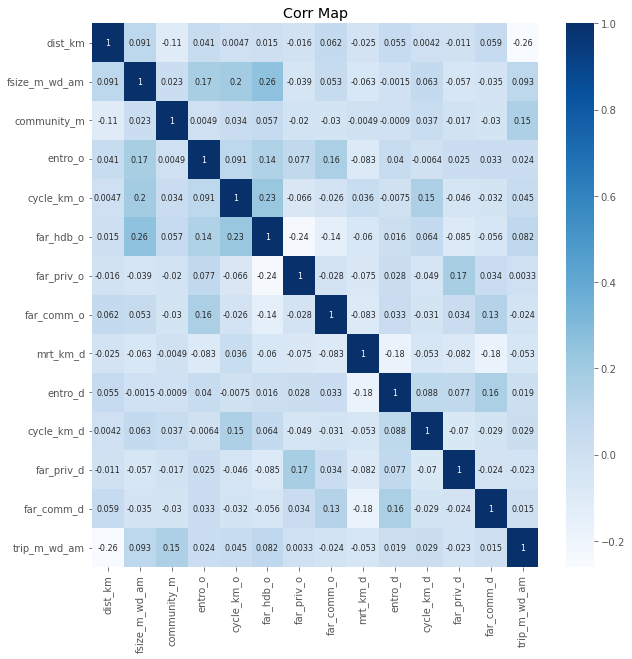

In [49]:
corr_plot(data.drop('p',axis=1))

In [374]:
result.params

Intercept       -4.296636
dist_km         -3.672753
fsize_m_wd_am    0.501296
mrt_km_d        -0.343594
far_hdb_o        0.277096
community_m      0.169796
entro_d          0.164014
far_comm_d       0.171260
far_priv_o       0.100184
far_priv_d      -0.070046
cycle_km_o       0.053615
entro_o          0.076945
far_hdb_d        0.053868
cycle_km_d       0.040579
far_comm_o      -0.040726
mrt_km_o         0.040729
dtype: float64

----
# 5. 缩小变量范围再次逐步回归

In [9]:
X_train = X_train.drop(['cycle_km_o','cycle_km_d','entro_d','far_priv_o'],axis=1)
X_test = X_test.drop(['cycle_km_o','cycle_km_d','entro_d','far_priv_o'],axis=1)
data = pd.concat([X_train,y_train],axis=1)
test_data= pd.concat([X_test,y_test],axis=1)
# new_result = result.params.drop(['mrt_km_o','entro_o','entro_d'])
# new_result 

In [12]:
new_model = stepwise_select(data, 'trip_m_wd_am')
new_result = new_model.fit()
new_result.summary()

aic is 135241.02545979418,continuing!
1
aic is 132341.21052024362,continuing!
2
aic is 131334.0259078679,continuing!
3
aic is 130501.3971543113,continuing!
4
formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_m + mrt_km_d 
----------------------------------------------------------------------------------------------------
initial aic is 130501.3971543113!
initial formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_m + mrt_km_d
backward selection over!
final formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_m + mrt_km_d 
aic is 129946.16640744107,continuing!
5
aic is 129693.88785022356,continuing!
6
aic is 129644.07120587473,continuing!
7
aic is 129618.11401631356,continuing!
8
formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_m + mrt_km_d + far_hdb_o + far_comm_d + far_priv_d + far_comm_o 
----------------------------------------------------------------------------------------------------
initial aic is 129618.11401631356!
initial formula is

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           trip_m_wd_am   No. Observations:               168866
Model:                            GLM   Df Residuals:                   168856
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64788.
Date:                Thu, 12 May 2022   Deviance:                   1.2958e+05
Time:                        21:16:55   Pearson chi2:                 2.37e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.1187      0.010   -210.530      0.000      -2.138      -2.099
dist_km          -1.4346      0.014   -105.089      0.000      -1.461      -1.408
fsize_m_wd_am     0.2948      0.007     44.130      0.000       0.282       0.308
community_m       0.1598      0.005     29.282      0.000       0.149       0.170
mrt_km_d         -0.2035      0.009    -22.937      0.000      -0.221      -0.186
far_hdb_o         0.1560      0.007     22.350      0.000       0.142       0.170
far_comm_d        0.1171      0.007     16.790      0.000       0.103       0.131
far_priv_d       -0.0539      0.007     -7.256      0.000      -0.068      -0.039
far_comm_o       -0.0484      0.008     -5.853      0.000      -0.065      -0.032
entro_o           0.0354      0.007      4.861      0.000       0.021       0.050
=================================================================================
"""

dropped:
set()
train:
accuracy: 0.8444920824795992
TP:3046	FN:25083
FP:1177	TN:139560


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------
test:
accuracy: 0.847054109324048
TP:1324	FN:10570
FP:499	TN:59979


  0%|          | 0/100 [00:00<?, ?it/s]

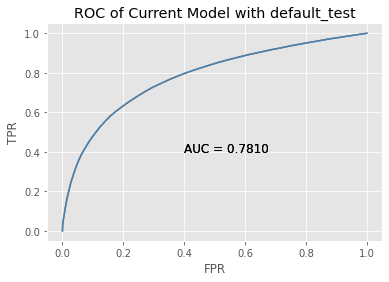

In [13]:
experiment_overview(train_data=data, test_data=test_data, result=new_result)


----
# 7. 添加交叉项并验证

In [14]:
new_result.params

Intercept       -2.118702
dist_km         -1.434638
fsize_m_wd_am    0.294847
community_m      0.159799
mrt_km_d        -0.203512
far_hdb_o        0.156043
far_comm_d       0.117069
far_priv_d      -0.053864
far_comm_o      -0.048382
entro_o          0.035416
dtype: float64

In [ ]:
# adds = ['far_comm_o','far_hdb_o']
# ncol_name='{}_{}'.format(adds[0],adds[1])
# confirmed = new_result.params.drop('Intercept').index
# formula = "{} ~ {}".format(
#                 'trip_m_wd_am',' + '.join((list(confirmed) + [ncol_name]))
#                 )
# formula

In [15]:
def test_cross_variables(data, adds, og_result, confirmed,train,test): 
        
        print('og AIC:{}'.format(og_result.aic))
        ncol_name='{}x{}'.format(adds[0],adds[1])
        data[ncol_name] = data[adds[0]] * data[adds[1]]
        train[ncol_name] = train[adds[0]] * train[adds[1]]
        test[ncol_name] = test[adds[0]] * test[adds[1]]
        test_data[ncol_name] = test_data[adds[0]] * test[adds[1]]
        formula = "{} ~ {}".format(
                'trip_m_wd_am',' + '.join((list(confirmed) + [ncol_name]))
                )
        link = sm.families.links.logit()
        # print(formula)
        # print(data)
        model = smf.glm(
                formula=formula, data=data, 
                family=sm.families.Binomial(link)
                )
        result = model.fit(full_output=True)
        # del data[ncol_name]
        
        
        print('new AIC:{}'.format(result.aic))
        return result.summary()
        # return result.summary()
        

In [16]:
a = test_cross_variables(data=data, adds=['entro_o','far_hdb_o'], og_result=new_result, confirmed=new_result.params.drop('Intercept').index, train=X_train, test=X_test)
a

og AIC:129596.46222066016
new AIC:129576.41164101374


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           trip_m_wd_am   No. Observations:               168866
Model:                            GLM   Df Residuals:                   168855
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64777.
Date:                Thu, 12 May 2022   Deviance:                   1.2955e+05
Time:                        21:17:50   Pearson chi2:                 2.40e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.1146      0.010   -209.447      0.000      -2.134      -2.095
dist_km              -1.4354      0.014   -105.117      0.000      -1.462      -1.409
fsize_m_wd_am         0.2932      0.007     43.841      0.000       0.280       0.306
community_m           0.1599      0.005     29.289      0.000       0.149       0.171
mrt_km_d             -0.2021      0.009    -22.751      0.000      -0.219      -0.185
far_hdb_o             0.1601      0.007     22.797      0.000       0.146       0.174
far_comm_d            0.1168      0.007     16.747      0.000       0.103       0.130
far_priv_d           -0.0551      0.007     -7.407      0.000      -0.070      -0.040
far_comm_o           -0.0512      0.008     -6.170      0.000      -0.067      -0.035
entro_o               0.0384      0.007      5.253      0.000       0.024       0.053
entro_oxfar_hdb_o    -0.0329      0.007     -4.701      0.000      -0.047      -0.019
=====================================================================================
"""

In [17]:
test_cross_variables(data=data, adds=['mrt_km_d','far_comm_d'], og_result=new_result, confirmed=new_result.params.drop('Intercept').index, train=X_train, test=X_test)

og AIC:129596.46222066016
new AIC:129597.65455216271


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           trip_m_wd_am   No. Observations:               168866
Model:                            GLM   Df Residuals:                   168855
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64788.
Date:                Thu, 12 May 2022   Deviance:                   1.2958e+05
Time:                        21:17:54   Pearson chi2:                 2.39e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.1172      0.010   -207.634      0.000      -2.137      -2.097
dist_km                -1.4344      0.014   -105.060      0.000      -1.461      -1.408
fsize_m_wd_am           0.2947      0.007     44.108      0.000       0.282       0.308
community_m             0.1598      0.005     29.284      0.000       0.149       0.171
mrt_km_d               -0.2024      0.009    -22.611      0.000      -0.220      -0.185
far_hdb_o               0.1559      0.007     22.332      0.000       0.142       0.170
far_comm_d              0.1222      0.009     13.774      0.000       0.105       0.140
far_priv_d             -0.0538      0.007     -7.243      0.000      -0.068      -0.039
far_comm_o             -0.0482      0.008     -5.836      0.000      -0.064      -0.032
entro_o                 0.0354      0.007      4.860      0.000       0.021       0.050
mrt_km_dxfar_comm_d     0.0087      0.009      0.919      0.358      -0.010       0.027
=======================================================================================
"""

In [18]:
del data['mrt_km_dxfar_comm_d']
del X_train['mrt_km_dxfar_comm_d']
del X_test['mrt_km_dxfar_comm_d']

In [19]:
test_cross_variables(data=data, adds=['far_comm_o','far_hdb_o'], og_result=new_result, confirmed=new_result.params.drop('Intercept').index, train=X_train, test=X_test)


og AIC:129596.46222066016
new AIC:129586.54614891938


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           trip_m_wd_am   No. Observations:               168866
Model:                            GLM   Df Residuals:                   168855
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64782.
Date:                Thu, 12 May 2022   Deviance:                   1.2956e+05
Time:                        21:17:58   Pearson chi2:                 2.38e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.1252      0.010   -207.204      0.000      -2.145      -2.105
dist_km                 -1.4349      0.014   -105.089      0.000      -1.462      -1.408
fsize_m_wd_am            0.2946      0.007     44.085      0.000       0.281       0.308
community_m              0.1596      0.005     29.238      0.000       0.149       0.170
mrt_km_d                -0.2031      0.009    -22.889      0.000      -0.221      -0.186
far_hdb_o                0.1481      0.007     19.985      0.000       0.134       0.163
far_comm_d               0.1175      0.007     16.859      0.000       0.104       0.131
far_priv_d              -0.0532      0.007     -7.165      0.000      -0.068      -0.039
far_comm_o              -0.0704      0.011     -6.683      0.000      -0.091      -0.050
entro_o                  0.0358      0.007      4.910      0.000       0.021       0.050
far_comm_oxfar_hdb_o    -0.0446      0.013     -3.396      0.001      -0.070      -0.019
========================================================================================
"""

In [20]:
test_cross_variables(data=data, adds=['community_m','dist_km'], og_result=new_result, confirmed=new_result.params.drop('Intercept').index, train=X_train, test=X_test)


og AIC:129596.46222066016
new AIC:129539.00813022291


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           trip_m_wd_am   No. Observations:               168866
Model:                            GLM   Df Residuals:                   168855
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64759.
Date:                Thu, 12 May 2022   Deviance:                   1.2952e+05
Time:                        21:18:03   Pearson chi2:                 2.10e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.1237      0.010   -210.778      0.000      -2.143      -2.104
dist_km                -1.4343      0.014   -105.188      0.000      -1.461      -1.408
fsize_m_wd_am           0.2945      0.007     44.133      0.000       0.281       0.308
community_m             0.0678      0.014      4.846      0.000       0.040       0.095
mrt_km_d               -0.2036      0.009    -22.923      0.000      -0.221      -0.186
far_hdb_o               0.1558      0.007     22.303      0.000       0.142       0.169
far_comm_d              0.1167      0.007     16.754      0.000       0.103       0.130
far_priv_d             -0.0540      0.007     -7.269      0.000      -0.069      -0.039
far_comm_o             -0.0484      0.008     -5.859      0.000      -0.065      -0.032
entro_o                 0.0354      0.007      4.857      0.000       0.021       0.050
community_mxdist_km    -0.1046      0.014     -7.258      0.000      -0.133      -0.076
=======================================================================================
"""

----
# 8. 加入交叉项并逐步回归

In [21]:
new_model_cross = stepwise_select(data, 'trip_m_wd_am')
new_result_cross = new_model_cross.fit()
new_result_cross.summary()

aic is 135241.02545979418,continuing!
1
aic is 132341.21052024362,continuing!
2
aic is 131295.78157636648,continuing!
3
aic is 130464.69434070705,continuing!
4
formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_mxdist_km + mrt_km_d 
----------------------------------------------------------------------------------------------------
initial aic is 130464.69434070705!
initial formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_mxdist_km + mrt_km_d
backward selection over!
final formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_mxdist_km + mrt_km_d 
aic is 129907.13517204435,continuing!
5
aic is 129657.67631041177,continuing!
6
aic is 129607.0648994068,continuing!
7
aic is 129580.64018510189,continuing!
8
formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_mxdist_km + mrt_km_d + far_hdb_o + far_comm_d + far_priv_d + far_comm_o 
----------------------------------------------------------------------------------------------------
initial aic is 1295

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           trip_m_wd_am   No. Observations:               168866
Model:                            GLM   Df Residuals:                   168853
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64742.
Date:                Thu, 12 May 2022   Deviance:                   1.2948e+05
Time:                        21:18:55   Pearson chi2:                 2.13e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.1260      0.010   -206.271      0.000      -2.146      -2.106
dist_km                 -1.4353      0.014   -105.215      0.000      -1.462      -1.409
fsize_m_wd_am            0.2927      0.007     43.811      0.000       0.280       0.306
community_mxdist_km     -0.1043      0.014     -7.235      0.000      -0.133      -0.076
mrt_km_d                -0.2018      0.009    -22.697      0.000      -0.219      -0.184
far_hdb_o                0.1523      0.007     20.431      0.000       0.138       0.167
far_comm_d               0.1169      0.007     16.778      0.000       0.103       0.131
far_priv_d              -0.0545      0.007     -7.327      0.000      -0.069      -0.040
far_comm_o              -0.0719      0.011     -6.829      0.000      -0.093      -0.051
entro_o                  0.0387      0.007      5.286      0.000       0.024       0.053
community_m              0.0680      0.014      4.858      0.000       0.041       0.095
entro_oxfar_hdb_o       -0.0317      0.007     -4.539      0.000      -0.045      -0.018
far_comm_oxfar_hdb_o    -0.0421      0.013     -3.212      0.001      -0.068      -0.016
========================================================================================
"""

dropped:
set()
train:
accuracy: 0.844498004334798
TP:2974	FN:25155
FP:1104	TN:139633


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------
test:
accuracy: 0.8472890067982093
TP:1304	FN:10590
FP:462	TN:60016


  0%|          | 0/100 [00:00<?, ?it/s]

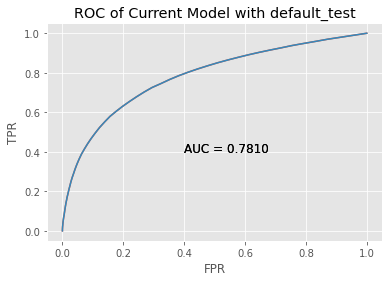

In [33]:
experiment_overview(train_data=data, test_data=test_data, result=new_result_cross)

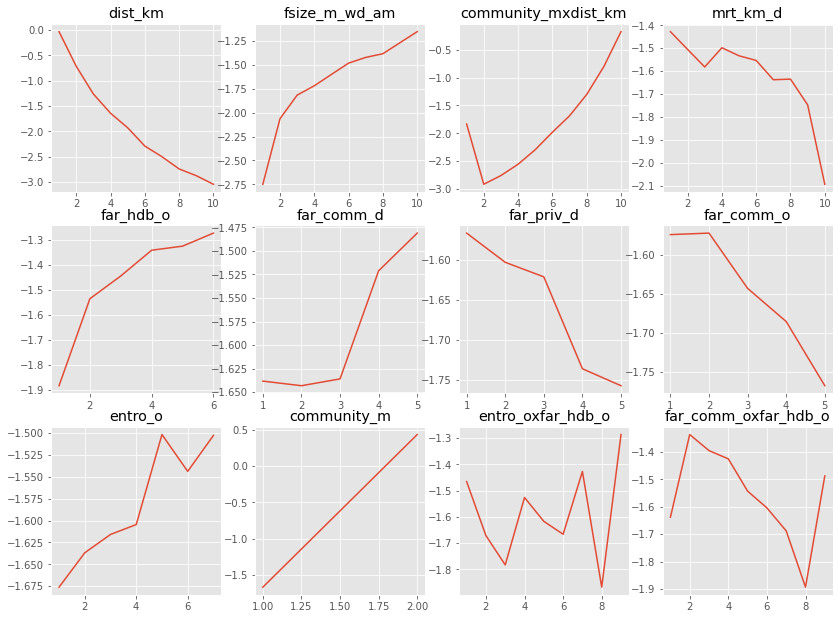

In [32]:
plt.style.use('ggplot')
logit_plot(result=new_result_cross,figname='logit_features_with_cross')

In [22]:
X_train = X_train.drop(['entro_oxfar_hdb_o'],axis=1)
X_test = X_test.drop(['entro_oxfar_hdb_o'],axis=1)
data = pd.concat([X_train,y_train],axis=1)
test_data = pd.concat([X_test,y_test],axis=1)

# new_result = result.params.drop(['mrt_km_o','entro_o','entro_d'])
# new_result

In [35]:
final_model_cross = stepwise_select(data, 'trip_m_wd_am')
final_result_cross = final_model_cross.fit()
final_result_cross.summary()

aic is 135241.02545979418,continuing!
1
aic is 132341.21052024362,continuing!
2
aic is 131295.78157636648,continuing!
3
aic is 130464.69434070705,continuing!
4
formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_mxdist_km + mrt_km_d 
----------------------------------------------------------------------------------------------------
initial aic is 130464.69434070705!
initial formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_mxdist_km + mrt_km_d
backward selection over!
final formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_mxdist_km + mrt_km_d 
aic is 129907.13517204435,continuing!
5
aic is 129657.67631041177,continuing!
6
aic is 129607.0648994068,continuing!
7
aic is 129580.64018510189,continuing!
8
formula is trip_m_wd_am ~ dist_km + fsize_m_wd_am + community_mxdist_km + mrt_km_d + far_hdb_o + far_comm_d + far_priv_d + far_comm_o 
----------------------------------------------------------------------------------------------------
initial aic is 1295

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           trip_m_wd_am   No. Observations:               168866
Model:                            GLM   Df Residuals:                   168854
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64753.
Date:                Wed, 06 Apr 2022   Deviance:                   1.2951e+05
Time:                        09:08:59   Pearson chi2:                 2.10e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.1302      0.010   -207.456      0.000      -2.150      -2.110
dist_km                 -1.4345      0.014   -105.188      0.000      -1.461      -1.408
fsize_m_wd_am            0.2943      0.007     44.088      0.000       0.281       0.307
community_mxdist_km     -0.1046      0.014     -7.252      0.000      -0.133      -0.076
mrt_km_d                -0.2032      0.009    -22.876      0.000      -0.221      -0.186
far_hdb_o                0.1479      0.007     19.956      0.000       0.133       0.162
far_comm_d               0.1171      0.007     16.823      0.000       0.103       0.131
far_priv_d              -0.0533      0.007     -7.178      0.000      -0.068      -0.039
far_comm_o              -0.0703      0.011     -6.679      0.000      -0.091      -0.050
entro_o                  0.0358      0.007      4.905      0.000       0.021       0.050
community_m              0.0677      0.014      4.835      0.000       0.040       0.095
far_comm_oxfar_hdb_o    -0.0443      0.013     -3.381      0.001      -0.070      -0.019
========================================================================================
"""

dropped:
{'community_mxdist_km', 'far_comm_oxfar_hdb_o'}
train:
accuracy: 0.8444920824795992
TP:3046	FN:25083
FP:1177	TN:139560


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------
test:
accuracy: 0.847054109324048
TP:1324	FN:10570
FP:499	TN:59979


  0%|          | 0/100 [00:00<?, ?it/s]

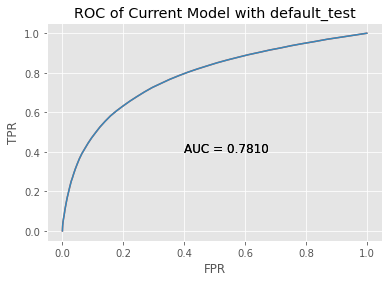

In [36]:
experiment_overview(train_data=data, test_data=test_data, result=new_result)


In [24]:
X_train

,dist_km,fsize_m_wd_am,community_m,entro_o,far_hdb_o,far_comm_o,mrt_km_d,far_priv_d,far_comm_d,far_comm_oxfar_hdb_o,community_mxdist_km
0,-0.714990,0.333575,-0.130648,0.790963,1.169348,-0.348315,-0.634448,-0.536495,0.018513,-0.407301,0.093412
1,0.253276,1.664617,-0.130648,0.080998,0.532539,-0.323742,-0.161832,-0.536495,-0.217058,-0.172406,-0.033090
2,-0.588455,-0.245281,-0.130648,0.069802,0.270277,-0.348315,0.078772,-0.005923,-0.347259,-0.094142,0.076881
3,1.392090,-0.582130,-0.130648,1.131255,-0.688689,-0.347753,-0.737564,-0.536495,-0.344091,0.239494,-0.181874
4,0.610875,-0.631185,-0.130648,0.306264,-0.688689,-0.287198,0.448271,2.621156,-0.347259,0.197790,-0.079810
...,...,...,...,...,...,...,...,...,...,...,...
168861,0.951969,0.379360,-0.130648,0.430761,-0.688689,0.024210,-0.247762,-0.536495,0.264480,-0.016673,-0.124373
168862,-0.703987,-0.448045,-0.130648,-0.116677,-0.688689,0.050457,-0.728971,1.513289,-0.347259,-0.034749,0.091975
168863,-0.775507,0.264897,-0.130648,-1.311919,-0.688689,-0.029811,-0.453995,-0.536495,-0.322631,0.020530,0.101319
168864,2.030266,0.170056,-0.130648,0.161262,1.322505,0.203630,-0.660227,-0.536495,-0.141665,0.269302,-0.265251


In [25]:
data.to_csv('')

,dist_km,fsize_m_wd_am,community_m,entro_o,far_hdb_o,far_comm_o,mrt_km_d,far_priv_d,far_comm_d,far_comm_oxfar_hdb_o,community_mxdist_km,trip_m_wd_am
0,-0.714990,0.333575,-0.130648,0.790963,1.169348,-0.348315,-0.634448,-0.536495,0.018513,-0.407301,0.093412,1
1,0.253276,1.664617,-0.130648,0.080998,0.532539,-0.323742,-0.161832,-0.536495,-0.217058,-0.172406,-0.033090,0
2,-0.588455,-0.245281,-0.130648,0.069802,0.270277,-0.348315,0.078772,-0.005923,-0.347259,-0.094142,0.076881,0
3,1.392090,-0.582130,-0.130648,1.131255,-0.688689,-0.347753,-0.737564,-0.536495,-0.344091,0.239494,-0.181874,0
4,0.610875,-0.631185,-0.130648,0.306264,-0.688689,-0.287198,0.448271,2.621156,-0.347259,0.197790,-0.079810,0
...,...,...,...,...,...,...,...,...,...,...,...,...
168861,0.951969,0.379360,-0.130648,0.430761,-0.688689,0.024210,-0.247762,-0.536495,0.264480,-0.016673,-0.124373,0
168862,-0.703987,-0.448045,-0.130648,-0.116677,-0.688689,0.050457,-0.728971,1.513289,-0.347259,-0.034749,0.091975,1
168863,-0.775507,0.264897,-0.130648,-1.311919,-0.688689,-0.029811,-0.453995,-0.536495,-0.322631,0.020530,0.101319,1
168864,2.030266,0.170056,-0.130648,0.161262,1.322505,0.203630,-0.660227,-0.536495,-0.141665,0.269302,-0.265251,0


In [26]:
X_train.columns

Index(['dist_km', 'fsize_m_wd_am', 'community_m', 'entro_o', 'far_hdb_o',
       'far_comm_o', 'mrt_km_d', 'far_priv_d', 'far_comm_d',
       'far_comm_oxfar_hdb_o', 'community_mxdist_km'],
      dtype='object')